# German Car Price Importance & Prediction w/LGBM

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

2024-04-21 03:04:49.601734: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 03:04:49.601871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 03:04:49.726324: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data preparation

In [ ]:
data0 = pd.read_csv("/kaggle/input/german-car-insights/gcar_data.csv")
data0=data0.dropna()
print(data0.columns.tolist())
cols=data0.columns.tolist()
display(data0.info())

['Unnamed: 0', 'brand', 'model', 'color', 'registration_date', 'year', 'price_in_euro', 'power_kw', 'power_ps', 'transmission_type', 'fuel_type', 'fuel_consumption_l_100km', 'fuel_consumption_g_km', 'mileage_in_km', 'offer_description']
<class 'pandas.core.frame.DataFrame'>
Index: 88584 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                88584 non-null  int64  
 1   brand                     88584 non-null  object 
 2   model                     88584 non-null  object 
 3   color                     88584 non-null  object 
 4   registration_date         88584 non-null  object 
 5   year                      88584 non-null  object 
 6   price_in_euro             88584 non-null  object 
 7   power_kw                  88584 non-null  object 
 8   power_ps                  88584 non-null  object 
 9   transmission_type         88584 non-null  object 

None

In [ ]:
from sklearn.preprocessing import LabelEncoder

def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object': 
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

In [ ]:
data0=labelencoder(data0)

# Target set & Train/Test split

In [ ]:
target=['price_in_euro']
dataX=data0.drop(target,axis=1)
dataY=data0[target]

In [ ]:
trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size=0.2, random_state=42)

In [ ]:
df_columns = list(trainX.columns)
print(df_columns)

['Unnamed: 0', 'brand', 'model', 'color', 'registration_date', 'year', 'power_kw', 'power_ps', 'transmission_type', 'fuel_type', 'fuel_consumption_l_100km', 'fuel_consumption_g_km', 'mileage_in_km', 'offer_description']


In [ ]:
train_df=trainX
test_df=testX

In [ ]:
train_df.columns=df_columns
test_df.columns=df_columns

In [ ]:
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [ ]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [ ]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [ ]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

100%|██████████| 1/1 [00:00<00:00, 42.56it/s]


createcreate_numeric_feature  0.021[s]


100%|██████████| 1/1 [00:00<00:00, 155.70it/s]

createcreate_numeric_feature  0.005[s]


# Model

In [ ]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None, 
             ):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)]
                   )

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [ ]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}

In [ ]:
y = trainY
ydf=pd.DataFrame(y)

In [ ]:
from sklearn.model_selection import KFold

for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params)
    


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2084
[LightGBM] [Info] Number of data points in the train set: 56693, number of used features: 14
[LightGBM] [Info] Start training from score 4525.414566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

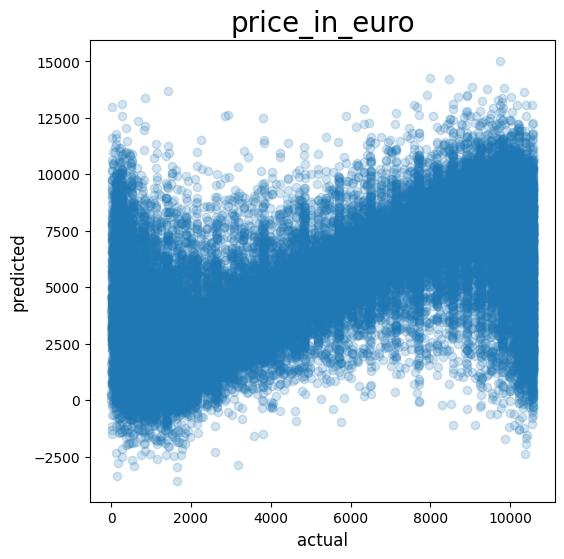

In [ ]:
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_ylabel('predicted',fontsize=12)
    ax.set_xlabel('actual',fontsize=12)
    ax.scatter(y,oof,alpha=0.2)

# Visualize Importance

In [ ]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig,ax

#fig, ax = visualize_importance(models, train_feat_df)

In [ ]:
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2084
[LightGBM] [Info] Number of data points in the train set: 56693, number of used features: 14
[LightGBM] [Info] Start training from score 4525.414566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

Text(0.5, 1.0, 'price_in_euro Imortance')

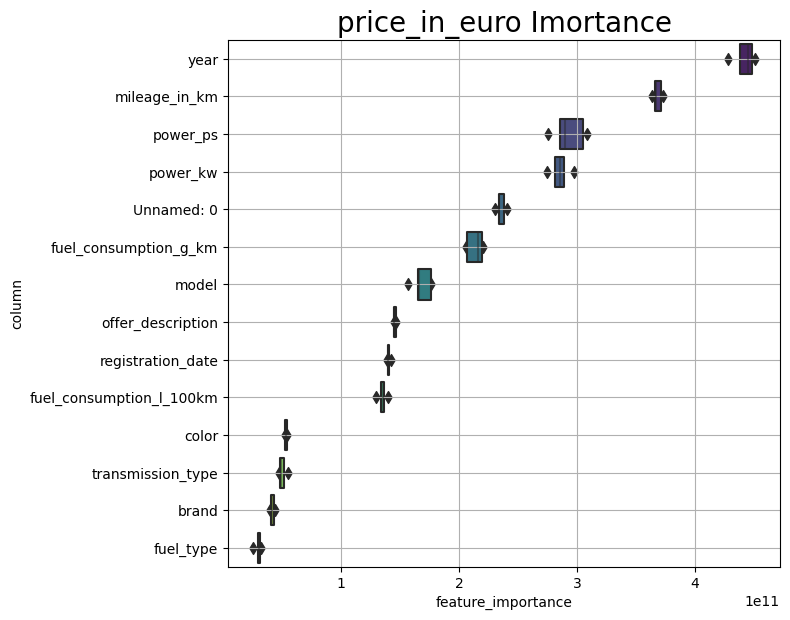

In [ ]:
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Imortance',fontsize=20)

In [ ]:
preds=[]
for i in range(5):
    preds += [models[i].predict(test_feat_df.values)/5]

In [ ]:
predsT=np.array(preds).T
preds2=[]
for item in predsT:
    value=sum(item)
    preds2+=[value]
print(preds2[0:5])

[2911.1263077564718, 2690.9590284871792, 1177.8620978650906, 3333.7159187553893, 5488.394011499875]


In [ ]:
print(len(testY),len(preds2))

17717 17717


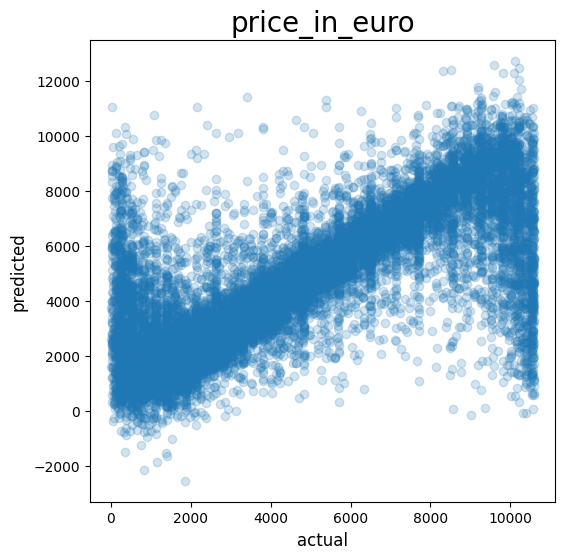

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
ax.set_title(target[0],fontsize=20)
ax.set_ylabel('predicted',fontsize=12)
ax.set_xlabel('actual',fontsize=12)
ax.scatter(testY,preds2,alpha=0.2)